# Dropout

[Yarin Kendall and Zoubin Ghahramani](https://arxiv.org/abs/1506.02142) introduced inference-time Dropout as a way to 
estimate uncertainty in deep neural networks. Based on variational 
inference theory and Bayesian neural networks -- where weights are 
distributions instead of fixed weights -- they see Dropout as a 
Bernoulli distribution, i.e. either `w` or `0`. 

If Dropout is used during the forward pass of a trained model at inference time,
one obtains different probabilities on every pass. If this is repeated, one
obtained a distribution of probabilities. The standard deviation of these distributions
can be interpreted as a measure of model uncertainty.

This can be seen as an ensemble approach where each forward pass evaluates
a slightly different model. 

Ingmar Glauche posed the following a question:
    
    "How much does the resulting uncertainty depend on the Dropout rate?"
    
To try to answer this empirically, here, I use a simple dataset and a standard ANN to investigate this.

# Data

First, we generate some simple but partly ambiguous data. 

We make two classes by sampling from 2 different 2D multivariate
normal distributions. 

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np

In [2]:
## data for class 0
n = 5000
mean = [-1.5, 0]
cov = [[1, 0], [0, 2]]  # diagonal covariance
px, py = np.random.multivariate_normal(mean, cov, n).T

X0 = np.array([px, py]).T
Y0 = np.zeros(n).T # labels = 0

## data for class 1
mean = [1.5, 0]
cov = [[1, 0], [0, 2]]  # diagonal covariance
px, py = np.random.multivariate_normal(mean, cov, n).T

X1 = np.array([px, py]).T
Y1 = np.ones(n).T # labels = 1

# combine data
X = np.vstack([X0, X1])
Y = np.hstack([Y0, Y1])
print(X.shape)
print(Y.shape)

(10000, 2)
(10000,)


Plot the data, with the color indicating the class

In [3]:
fig, ax = plt.subplots(1,)
ax.scatter(X[:,0],X[:,1],c=Y,alpha=0.05)
_ = ax.axis('equal')

Split the data in a train and test set

In [4]:
#from keras.utils import to_categorical
#Y = to_categorical(Y)


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=42)

# Network

We construct a simple classifier NN with Dropout.

With the `training` flag, Dropout is not only executed at training time, but also at inference time. 

In [113]:
def nn_model(dropout_rate, hidden_units=32):
    from keras import layers, models
    
    i = layers.Input((2,))
    #x = layers.Dense(64, activation='relu')(i)
    x = layers.Dense(units=hidden_units, activation='relu')(i)
    x = layers.Dropout(rate=dropout_rate)(x, training=True) # <== dropout
    o = layers.Dense(1, activation='sigmoid')(x)
    
    return models.Model(inputs=i, outputs=o)
    

In [170]:
model = nn_model(dropout_rate=0.5)
model.compile(optimizer='adam', loss='binary_crossentropy')

# Train network

In [171]:
%%time

batch_size = 1024
epochs = 50

history = model.fit(X_train, Y_train, 
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_test, Y_test))

CPU times: user 6.05 s, sys: 132 ms, total: 6.18 s
Wall time: 5.41 s


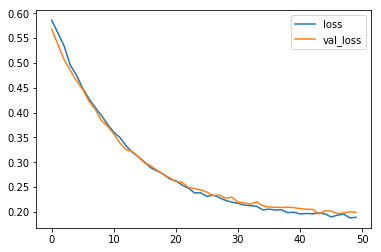

In [172]:
fig, ax = plt.subplots(1,)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.legend()

# Prediction 

Due to inference-time Dropout, we get a difference prediction every time we do a forward pass.

Here, we do it `n=3` times and get slightly different predictions (indicated by colors):

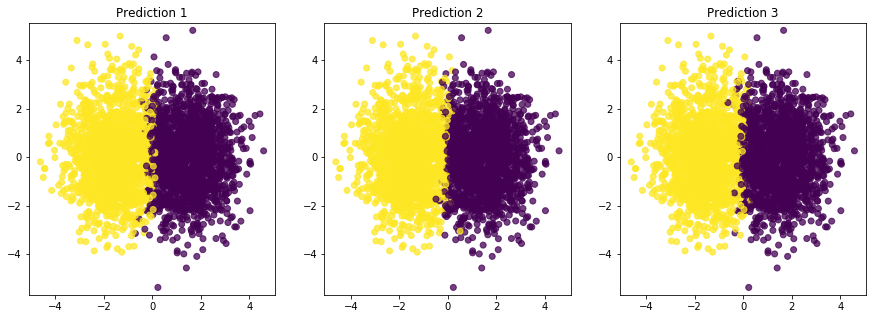

In [173]:
n = 3
fig, ax = plt.subplots(1,n,figsize=(n*5,5))

for i in range(n):
    
    # predict
    y_pred = model.predict(X_test)
    
    # plot
    ax[i].scatter(X_test[:,0],X_test[:,1], c=np.squeeze(y_pred<0.5), alpha=0.75)
    ax[i].set_title('Prediction {}'.format(i+1))
    _ = ax[i].axis('equal')

Let's split the data set in ambiguous data points, where `x` coordinate is between `(-r, r)`, and non-ambiguous data points. 

In [174]:
r = 1.0
X_ambiguous = X_test[ (X_test[:,0] > -r) &(X_test[:,0] < r) ]
X_nonambiguous = X_test[ (X_test[:,0] <= -2*r) | (X_test[:,0] >= 2*r) ]
X_ambiguous.shape

(1040, 2)

If we now predict the class probabilities of `sample=0` a `n=1000` times and plot the histograms, 
we can fit them with a normal distribution. 

The standard deviation of the fitted normal distribution is the epistemic uncertainty. 

The probability for class 0 = 0.97 +/- 0.05


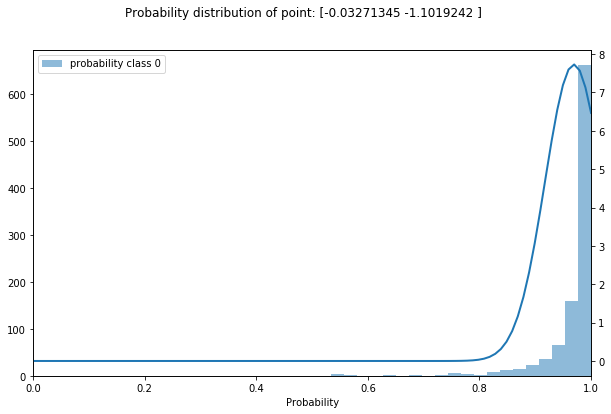

In [175]:
n = 1000
sample = 0
data_sample = X_nonambiguous[sample][np.newaxis, ...]

# predict the class probabilities of the `sample`
# by performing `n` forward passes with dropout
probs = np.array([model.predict(data_sample)[0] for i in range(n)])

fig, ax = plt.subplots(figsize=(10,6))

# plot the histograms of the probabilities
fig.suptitle('Probability distribution of point: {}'.format(X_ambiguous[:1][0]))
_ = ax.hist(probs[:,0], bins=20, alpha=0.5, label='probability class 0')
ax.set_xlabel('Probability')
#_ = ax.hist(probs[:,1], bins=20, alpha=0.5, label='probability class 1')
_ = ax.legend()
_ = plt.legend(loc='best')
ax.set_xlim([0.,1.])

# fit a normal distribution and plot them
ax2 = ax.twinx()
from scipy.stats import norm
for i in range(1):
    # Fit a normal distribution to the data:
    mu, std = norm.fit(probs[:,i])
    print('The probability for class {} = {:.2f} +/- {:.2f}'.format(i, mu, std))
    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax2.plot(x, p, linewidth=2)

We can now repeat this for all the test sample (`X_test`) and plot the probabilities *and* uncertainties as a scatter plot.

In [176]:
%%time
n = 100
probs = np.squeeze(np.array([model.predict(X_test) for i in range(n)]))

CPU times: user 17.7 s, sys: 956 ms, total: 18.7 s
Wall time: 13.4 s


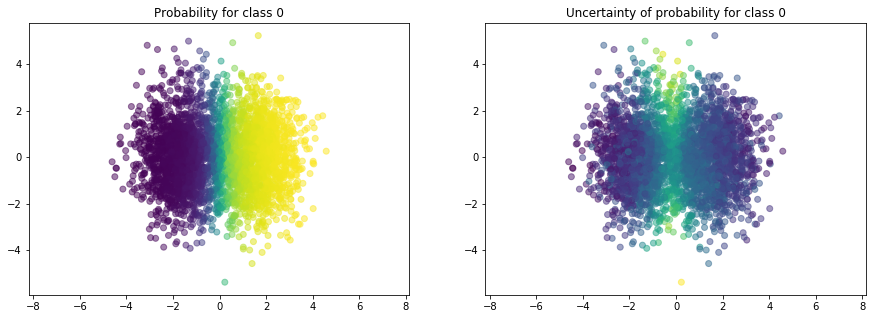

In [177]:
prob_class0_mean = np.mean(probs, axis=0)
prob_class0_std = np.std(probs, axis=0)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].set_title('Probability for class 0')
cax0 = ax[0].scatter(X_test[:,0],X_test[:,1],c=prob_class0_mean,alpha=0.5)
_ = ax[0].axis('equal')
#plt.colorbar(cax0)

ax[1].set_title('Uncertainty of probability for class 0')
cax1 = ax[1].scatter(X_test[:,0],X_test[:,1],c=prob_class0_std,alpha=0.5)
_ = ax[1].axis('equal')
#plt.colorbar(cax1)

As expected, we'll see that ambiguous data points between the two clusters have highest uncertainty.

Note that the samples with $p(class=0) \approx 0.5$, at the border, can have low uncertainty. That is, the network predict with reasonable certainty that these sample have 50/50 probability of belonging to either class. 

# Relation between dropout rate and uncertainty

First, we define an array of different dropout rates:

In [157]:
dropout_rates = np.linspace(0.0, 0.9, 19)
dropout_rates

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 ])

Then, we construct aand compile list of NN models, one for each dropout rate:

In [158]:
# define 10 model with different dropout rates
models = [ nn_model(rate) for rate in dropout_rates]

# compile the models
_ = [model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) for model in models]

Finally, we train each model for the same training data set. 

Note: we are training 10 models for `epochs=20` each. This can become fairly **time-consuming**.

In [159]:
%%time

# train the models
histories = [model.fit(X_train, Y_train, 
                       batch_size=batch_size,
                       epochs=epochs,
                       verbose=0,
                       validation_data=(X_test, Y_test)) for model in models]

CPU times: user 1min 34s, sys: 2.65 s, total: 1min 36s
Wall time: 1min 20s


Briefly check whether the validation accuracies are similar. Unsurprisingly, we may see that extreme dropout rates (`>0.8`) result in lower accuracies. This because of a decrease in model capacity. 

(0, 1)

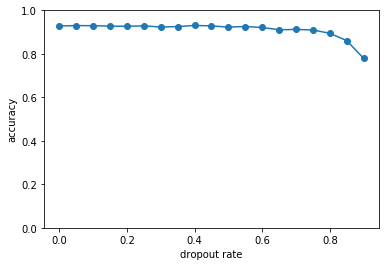

In [160]:
scores = [model.evaluate(X_test, Y_test, verbose=0) for model in models]
accuracies = np.array(scores)[:,1]

fig, ax = plt.subplots()
ax.plot(dropout_rates, accuracies, '-o')
ax.set_xlabel('dropout rate')
ax.set_ylabel('accuracy')
ax.set_ylim([0,1])

### Visualize relation between dropout rate and uncertainty

Now, we take a sample as before and predict the class probability 
for class 0 many times (`n=100`) to get a *posterior* distribution.

We repeat this for each model with different dropout rates.

Afterwards, we plot the uncertainty of the probability again the dropout rate of the model.

In [161]:
%%time

n = 50
#sample = 2
#data_sample = X_ambiguous[sample][np.newaxis, ...]
#sample = 2
data_sample = X_ambiguous#[np.newaxis, ...]

mus = [] # mean
sigmas = [] # stdev
for model in models:
    print('.', end='')
    probs = np.squeeze(np.array([model.predict(data_sample) for i in range(n)]))
    mus.append( np.mean(probs, axis=0) ) 
    sigmas.append( np.std(probs, axis=0) ) 

# take mean stdev over all samples
print(np.array(sigmas).shape)
sigmas = np.mean(np.array(sigmas), axis=1)

...................(19, 1040)
CPU times: user 1min 6s, sys: 2.5 s, total: 1min 9s
Wall time: 54.4 s


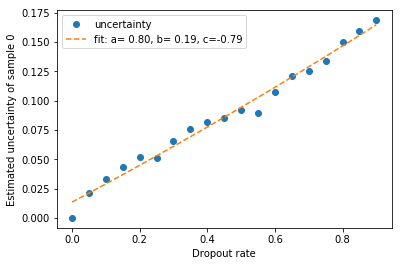

In [162]:
#plt.plot(dropout_rates, mus, '-o', label='mean probability')
plt.plot(dropout_rates, sigmas, 'o', label='uncertainty')
plt.xlabel('Dropout rate')
plt.ylabel('Estimated uncertainty of sample {}'.format(sample))

#from scipy.stats import linregress
#slope, intercept, r_value, p_value, std_err = linregress(dropout_rates[2:],sigmas[2:])
#plt.plot(dropout_rates, intercept + slope*dropout_rates, 'r', label='slope = {:.2f}\nr = {:.2f}'.format(slope, r_value))

from scipy.optimize import curve_fit
def func(x, a, b, c): return a * np.exp(b * x) + c
p0 = (1.0,0.15,-1.0)
popt, pcov = curve_fit(func, dropout_rates, sigmas, p0=p0)
plt.plot(dropout_rates, func(dropout_rates, *popt), '--', label='fit: a={:5.2f}, b={:5.2f}, c={:5.2f}'.format(*popt))

plt.legend()


*Interestingly, it seems this relation is linear for ambiguous samples and exponential for non-ambiguous samples... At least, in this simplistic example... Why is this???*

# Compensation of dropout by number of hidden units

One explanation of this behavior is that the capacity of the models decreases with the dropout rate. (For instance, a model with 99% dropout has few connections left and has therefore small learning capacity.)

However, what happens if we "compensate" the loss of connections/weights/parameters due to Dropout by adding hidden units, and thereby connections?

In this case, the number of active (i.e. nonzero) weights remains the same for all dropout rates. Therefore, the capacity of the model remains fixed for changes in dropout rate.


In [163]:
#dropout_rates = np.linspace(0.0, 0.9, 19)
print(dropout_rates)

# note: here, we change the number of hidden units, although we actually aim
# to change the number of connections. In this case, this is identical because the
# dropout layer is connected to a single output node.
hidden_units = [int(np.ceil((32 * (1.0 / (1.0-rate))))) for rate in dropout_rates]
print(hidden_units)


[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9 ]
[32, 34, 36, 38, 40, 43, 46, 50, 54, 59, 64, 72, 81, 92, 107, 128, 161, 214, 321]


In [164]:
# define 10 model with different dropout rates
models2 = [ nn_model(rate, hidden_units=units) for rate, units in zip(dropout_rates, hidden_units)]

# compile the models
_ = [model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) for model in models2]

Finally, we train each model for the same training data set. 

Note: we are training 10 models for 100 epochs each. This can become fairly **time-consuming**.

In [165]:
%%time

# train the models
histories2 = [model.fit(X_train, Y_train, 
                       batch_size=batch_size,
                       epochs=epochs,
                       verbose=0,
                       validation_data=(X_test, Y_test)) for model in models2]

CPU times: user 1min 49s, sys: 2.73 s, total: 1min 51s
Wall time: 1min 35s


Briefly check whether the validation accuracies are similar. Here, we should **not** see lower accuracies at extreme dropout rates (`>0.9`), because the capacity of the model should remain fixed. 

(0, 1)

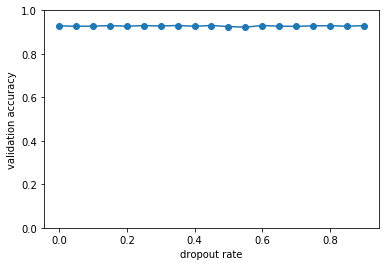

In [166]:
scores = [model.evaluate(X_test, Y_test, verbose=0) for model in models2]
accuracies = np.array(scores)[:,1]

fig, ax = plt.subplots()
ax.plot(dropout_rates, accuracies, '-o')
ax.set_xlabel('dropout rate')
ax.set_ylabel('validation accuracy')
ax.set_ylim([0,1])

### Visualize relation between dropout rate and uncertainty

Now, we take a sample as before and predict the class probability 
for class 0 many times to get a *posterior* distribution.

We repeat this for each model with different dropout rates.

Afterwards, we plot the uncertainty of the probability again the dropout rate of the model.

In [167]:
%%time

#n = # as above
#sample = # as above
#data_sample = # as above

mus2 = [] # mean
sigmas2 = [] # stdev
for model in models2:
    print('.', end='')
    probs = np.squeeze(np.array([model.predict(data_sample) for i in range(n)]))
    mus2.append( np.mean(probs, axis=0) ) 
    sigmas2.append( np.std(probs, axis=0) ) 

# take mean stdev over all samples
print(np.array(sigmas2).shape)
sigmas2 = np.mean(np.array(sigmas2), axis=1)

...................(19, 1040)
CPU times: user 1min 17s, sys: 2.6 s, total: 1min 19s
Wall time: 1min 4s


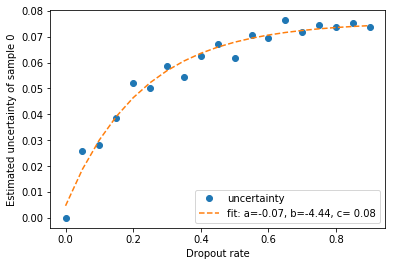

In [168]:
#plt.plot(dropout_rates, mus, '-o', label='mean probability')
plt.plot(dropout_rates, sigmas2, 'o', label='uncertainty')
plt.xlabel('Dropout rate')
plt.ylabel('Estimated uncertainty of sample {}'.format(sample))

#from scipy.stats import linregress
#slope2, intercept2, r_value2, p_value2, std_err = linregress(dropout_rates[2:], sigmas2[2:])
#plt.plot(dropout_rates, intercept2 + slope2*dropout_rates, 'r', label='slope = {:.2f}\nr = {:.2f}'.format(slope2, r_value2))

from scipy.optimize import curve_fit
def func(x, a, b, c): return a * np.exp(b * x) + c
popt2, pcov = curve_fit(func, dropout_rates, sigmas2, p0=(0.2,-1.5,0.0))
plt.plot(dropout_rates, func(dropout_rates, *popt2), '--', label='fit: a={:5.2f}, b={:5.2f}, c={:5.2f}'.format(*popt2))
plt.legend()

Now, plot both in the same plot:

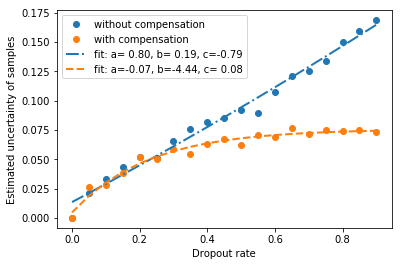

In [178]:

line1, = plt.plot(dropout_rates, sigmas, 'o', label='without compensation')
line2, = plt.plot(dropout_rates, sigmas2, 'o', label='with compensation')
plt.xlabel('Dropout rate')
plt.ylabel('Estimated uncertainty of samples')

#plt.plot(dropout_rates, intercept + slope*dropout_rates, 'black', linestyle='-.', label='slope = {:.2f}, r = {:.2f}'.format(slope, r_value))
#plt.plot(dropout_rates, intercept2 + slope2*dropout_rates, 'black', linestyle='--', label='slope = {:.2f}, r = {:.2f}'.format(slope2, r_value2))
plt.plot(dropout_rates, func(dropout_rates, *popt), 
         color = line1.get_color(), linestyle='-.', lw = 2,
         label='fit: a={:5.2f}, b={:5.2f}, c={:5.2f}'.format(*popt))
plt.plot(dropout_rates, func(dropout_rates, *popt2), 
         color = line2.get_color(),  linestyle='--', lw = 2,
         label='fit: a={:5.2f}, b={:5.2f}, c={:5.2f}'.format(*popt2))

plt.legend()


# Conclusions

1. Uncertainty increases as a function of the dropout rate.
   1. for ambiguous data points, this increases approximately linearly (without compensation)
   1. for non-ambigous data points, this seems to increase exponentially. The stdev is overestimated because PDFs are not normally distributed.

2. Compensation for the loss of capacity by adding connections/hidden units alleviates this effect.

3. However, a (saturated) increase in uncertainty is still present. This may be expected
   from the fact that with `dropout_rate = 0.0`, the estimated uncertainty is necessarily `0.0`. 
   Thus, the saturation constant could be considered as the *true estimated uncertainty*. 
   
4. Advice. To approximate the true estimated uncertainty:
     - take high dropout rate (to prevent underestimation of uncertainty) and 
     - high number of hidden units (compensate for loss of model capacity)
     
In the limit, this is equivalent to ensemble approach, where one produces a PDF based on independent models. 



 